In [77]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [78]:
import torch
import h5py

hip_fn = "/niddk-data-central/iWatch/pre_processed_seg/H/10s_val.h5"
with h5py.File(hip_fn, 'r') as f:
    data = f['x'][:]
    labels = f['y'][:]

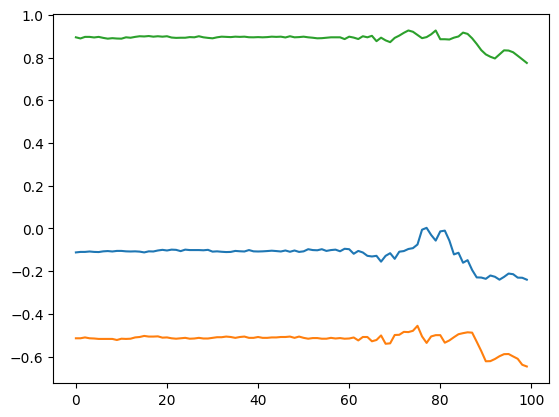

In [79]:
# generate a random idx
random_indx = 6089
sample_data = data[random_indx] # (100,3)
# plot sample_data
import matplotlib.pyplot as plt

for i in range(3):
    sample_data_i = sample_data[:, i]  # Extract the i-th channel data
    plt.plot(sample_data_i, label=f'Channel {i+1}')

We will compare 3 baseline:
* Linear Interp.
* Nearest Neighborhood
* Syncronize Masking MAE
* Crossmodality MAE

Metric Using
* MAE (mean absolute error) and MSE (mean square error)

### IMPORTANT: 
* For now just use 80% mask for all. In the future, run it from (10% to 90%) mask with 10% incremental
* We can also ablate along the input length (This would be harder since we need to interpolate the position embedding of our MAE)

## Input visualization
treating them as [6,200] image

In [80]:
from models_mae import MaskedAutoencoderViT
import torch
cross_6_200_model = MaskedAutoencoderViT(
    img_size=[3, int(100)],
    patch_size=[1, int(5)],
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
    is_eval=True,
)

cross_6_200_model_checkpoint = torch.load('/niddk-data-central/leo_workspace/MoCA_result/ckpt/iWatch-Hipps_5_mask_0.75_bs_256_blr_None_epoch_100/2025-04-23_20-41/checkpoint-20.pth',map_location='cpu')
msg = cross_6_200_model.load_state_dict(cross_6_200_model_checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


In [81]:
# print(normalized_sample.shape)
# normalized_sample = torch.tensor(normalized_sample)
# with torch.no_grad():
#     loss, pred, mask = cross_6_200_model(sample.unsqueeze(0).unsqueeze(0), mask_ratio=0.8,masking_scheme='random_imputation')
#     print('mse loss',loss)

# pred = cross_6_200_model.unpatchify(pred).squeeze()
# normalize_pred = (pred - pred.mean(dim=1,keepdim=True)) / pred.std(dim=1,keepdim=True)
# #normalize_pred=pred
# print(normalize_pred.shape)
# print(mask.shape)

In [82]:

# from models_mae import MaskedAutoencoderViT
# import torch
# sync_6_200_model = MaskedAutoencoderViT(
#     img_size=[6, int(200)],
#     patch_size=[1, int(20)],
#     in_chans=1,
#     embed_dim=768,
#     depth=12,
#     num_heads=12,
#     decoder_embed_dim=512,
#     decoder_depth=8,
#     decoder_num_heads=16,
#     mlp_ratio=4,
#     is_eval=True,
# )

# #cross_6_200_model_checkpoint = torch.load('../persistent-data/MAE_Accelerometer/experiments/1195(p200_10_alt_0.0005)/checkpoint-7999.pth',map_location='cpu')
# sync_6_200_model_checkpoint = torch.load('/home/jovyan/persistent-data/MAE_Accelerometer/experiments/185(p200_10_syn_0.0005)/checkpoint-3999.pth',map_location='cpu')
# #cross_6_200_model_checkpoint = torch.load('checkpoint-3999.pth',map_location='cpu')
# #/data/MAE_Accelerometer/experiments/62(p200_10_alt_0.0005_norm)/checkpoint-3999.pth
# msg = sync_6_200_model.load_state_dict(sync_6_200_model_checkpoint['model'], strict=False)
# print(msg)

In [83]:
# print(normalized_sample.shape)
# normalized_sample = torch.tensor(normalized_sample)
# with torch.no_grad():
#     loss, pred, mask = sync_6_200_model(sample.unsqueeze(0).unsqueeze(0), mask_ratio=0.8,masking_scheme='random_imputation')
#     #mask = mask.repeat(1, 6) 
#     print('mse loss',loss)
#     print(pred.shape)

# pred = sync_6_200_model.unpatchify(pred).squeeze()
# normalize_pred = (pred - pred.mean(dim=1,keepdim=True)) / pred.std(dim=1,keepdim=True)
# #normalize_pred=pred
# print(normalize_pred.shape)

In [84]:
from tqdm import tqdm
import numpy as np
import torch
from scipy.interpolate import interp1d
from sklearn.impute import KNNImputer


# Linear Interpolation Imputation
def linear_interpolation(tensor, mask):
    """
    Perform linear interpolation on a single sample of shape [6, 200].
    
    Parameters:
    tensor (torch.Tensor): The input tensor with shape [6, 200].
    mask (torch.Tensor): Binary mask with shape [6, 200], where 1 indicates missing values and 0 indicates observe values.
    
    Returns:
    torch.Tensor: The imputed tensor with interpolated values.
    """
    imputed_tensor = tensor.clone()
    for i in range(tensor.shape[0]):  # Loop over each feature (channel)
        observed_indices = torch.where(mask[i] == 0)[0]
        missing_indices = torch.where(mask[i] == 1)[0]

        if len(observed_indices) < 2:  # Ensure there are enough points for interpolation
            imputed_tensor[i, missing_indices] = 0  # Fill missing values with zero
            continue

        # Perform linear interpolation on observed values
        f = interp1d(observed_indices.cpu(), tensor[i, observed_indices].cpu(), kind='linear',fill_value=(-1,1),bounds_error=False)#, fill_value="extrapolate")
        
        # Interpolated values
        interpolated_values = torch.tensor(f(missing_indices.cpu()), dtype=tensor.dtype).to(tensor.device)
        
        # Assign interpolated values to missing indices
        imputed_tensor[i, missing_indices] = interpolated_values

    return imputed_tensor

# Nearest Neighbor Imputation within each channel
def impute_nearest_neighbor(tensor, mask, n_neighbors=5):
    """
    Impute missing values in a [6, 200] tensor using nearest neighbors and a mask.
    
    Parameters:
        tensor (torch.Tensor): The input tensor of shape [6, 200].
        mask (torch.Tensor): A boolean mask of shape [6, 200], where True indicates positions to impute.
        n_neighbors (int): The number of neighbors to use for imputation.
    
    Returns:
        torch.Tensor: The tensor with imputed values, retaining original values where mask is False.
    """
    # if tensor.shape != (6, 200) or mask.shape != (6, 200):
    #     raise ValueError("Input tensor and mask must both have shape [6, 200].")
    
    # Convert tensor to numpy array for KNNImputer compatibility
    tensor_np = tensor.numpy()
    mask_np = mask.bool().numpy()  # Ensure the mask is boolean
    
    # Apply the mask: set values to NaN where mask is True
    tensor_with_nan = tensor_np.copy()
    tensor_with_nan[mask_np] = np.nan

    # Create the KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors,keep_empty_features=True)

    # Impute missing values
    imputed_tensor = imputer.fit_transform(tensor_with_nan)
    imputed_tensor = torch.from_numpy(imputed_tensor).to(tensor.dtype)  # Match input dtype
    
    return imputed_tensor

# TODO: Implement MICE Imputation with above format
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer
from sklearn.impute import IterativeImputer

def impute_mice(tensor, mask, max_iter=10, 
                random_state=0, fallback_value=0.0):
    """
    Impute missing values in a [6, 200] tensor using MICE and a mask.
    For columns with all missing values, a fallback value is used.
    """
    # if tensor.shape != (6, 200) or mask.shape != (6, 200):
    #     raise ValueError("Input tensor and mask must both have shape [6, 200].")
    
    # Convert to numpy arrays.
    tensor_np = tensor.numpy()
    mask_np = mask.bool().numpy()  # ensure boolean
    
    # Set missing values to np.nan.
    tensor_with_nan = tensor_np.copy()
    tensor_with_nan[mask_np] = np.nan

    # Identify columns that are completely missing.
    all_missing = np.all(np.isnan(tensor_with_nan), axis=0)
    cols_to_impute = ~all_missing

    # Impute only columns that have at least one observed value.
    imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)
    imputed_partial = imputer.fit_transform(tensor_with_nan[:, cols_to_impute])
    
    # Prepare the full imputed array.
    imputed_tensor_np = np.empty_like(tensor_with_nan)
    # Fill imputed columns.
    imputed_tensor_np[:, cols_to_impute] = imputed_partial
    # For columns with all missing values, fill with the fallback.
    imputed_tensor_np[:, all_missing] = fallback_value

    # Convert back to torch.Tensor.
    imputed_tensor = torch.from_numpy(imputed_tensor_np).to(tensor.dtype)
    return imputed_tensor

# Evaluation function
def evaluate_imputation(imputed, original, mask):
    """
    Calculate MAE and MSE for the imputation compared to the original data.

    Parameters:
    imputed (torch.Tensor): Imputed data tensor.
    original (torch.Tensor): Original data tensor.
    mask (torch.Tensor): Binary mask tensor, where 0 indicates observed values and 1 indicates missing values.

    Returns:
    tuple: MAE and MSE for the imputation.
    """
    error = (imputed - original)* mask  # Only consider missing values
    mae = torch.mean(torch.abs(error)).item()
    #print('max error:',torch.max(error))
    mse = torch.mean(error ** 2).item()
    return mae, mse


# Random Imputation

In [92]:
# Convert (BS, 100,3) to (BS, 3,100)
test_set = torch.from_numpy(data).float().permute(0, 2, 1)  # Shape: (BS, 3, 100)
print(test_set.shape)
# Normalize over the last dimension (L), which is channel-independent normalization
# random_imput_test_set = (
#     (random_imput_test_set - random_imput_test_set.min(dim=2, keepdim=True)[0]) /
#     (random_imput_test_set.max(dim=2, keepdim=True)[0] - random_imput_test_set.min(dim=2, keepdim=True)[0] + 1e-8)
# )

# Print the shape to verify

# randomly select 512 random indices
random_indices = np.random.choice(test_set.shape[0], size=512, replace=False)
# Select the random samples
random_imput_test_set = test_set[random_indices]

abs_mean = random_imput_test_set.abs().mean(dim=(1, 2), keepdim=True)  # shape: [512, 1, 1]
random_imput_test_set = random_imput_test_set / abs_mean

print(random_imput_test_set.shape) # 512, 3, 100


torch.Size([394842, 3, 100])
torch.Size([512, 3, 100])


In [86]:
def mean_std_normalize(data):
    """Mean and standard deviation normalize a numpy array."""
    return (data - torch.mean(data)) / torch.std(data)

# def channelwise_normalization(tensor):
#     """
#     Performs channelwise normalization over the last dimension of a tensor with shape [BS, 1, 6, 200].
    
#     Parameters:
#         tensor (torch.Tensor): Input tensor of shape [BS, 1, 6, 200].
        
#     Returns:
#         torch.Tensor: Normalized tensor.
#     """
#     # Ensure the input tensor has the expected shape
#     if tensor.dim() != 4 or tensor.size(1) != 1 or tensor.size(2) != 6:
#         raise ValueError("Input tensor must have shape [BS, 1, 6, 200]")
    
#     # Calculate mean and standard deviation along the last dimension
#     mean = tensor.mean(dim=-1, keepdim=True)  # Keep dimensions for broadcasting
#     std = tensor.std(dim=-1, keepdim=True) + 1e-6  # Add epsilon to prevent division by zero
    
#     # Perform channel-wise normalization
#     normalized_tensor = (tensor - mean) / std
    
#     return normalized_tensor

def channelwise_normalization(tensor):
    """
    Performs channelwise min-max normalization over the last dimension of a tensor with shape [BS, 1, 6, 200].
    
    Parameters:
        tensor (torch.Tensor): Input tensor of shape [BS, 1, 6, 200].
        
    Returns:
        torch.Tensor: Normalized tensor with values scaled between 0 and 1.
    """
    # Ensure the input tensor has the expected shape
    if tensor.dim() != 4 or tensor.size(1) != 1 or tensor.size(2) != 6:
        raise ValueError("Input tensor must have shape [BS, 1, 6, 200]")
    
    # Compute minimum and maximum values along the last dimension
    min_val = tensor.min(dim=-1, keepdim=True).values  # Keep dimensions for broadcasting
    max_val = tensor.max(dim=-1, keepdim=True).values  # Keep dimensions for broadcasting
    
    # Avoid division by zero for uniform tensors
    range_val = max_val - min_val + 1e-6  # Add epsilon to prevent division by zero
    
    # Perform channel-wise min-max normalization
    normalized_tensor = (tensor - min_val) / range_val
    
    return normalized_tensor


In [93]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

def plot_sample(data, title, cmap='bwr'):
    plt.figure(figsize=(12, 2))  # Set figure size to make it elongated
    plt.imshow(data, cmap=cmap, aspect='auto')  # 'bwr' colormap for red-blue scale
    plt.colorbar(label="Signal Intensity")  # Optional color scale bar
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.xticks([])  # Removes x-axis ticks
    plt.yticks([])  # Removes y-axis ticks
    plt.show()

def baseline(random_imput_test_set, missing_ratio=0.8, 
             mask_scheme='random_imputation', model1=None, model2=None):
    """
    Calculate the overall mean statistics for linear, nearest neighbor, and MICE imputation.

    Parameters:
    random_imput_test_set (torch.Tensor): The dataset for imputation. Expected shape [BS, 1, 6, 200]
    missing_ratio (float): Ratio of missing data in each sample.
    mask_scheme (str): The masking scheme to use.
    model1 (torch.nn.Module): The first model used for imputation.
    model2 (torch.nn.Module): The second model used for imputation.

    Returns:
    dict: A dictionary with the overall mean for each performance metric.
    """
    print('Input shape:', random_imput_test_set.shape)
    if model1 is None:
        raise ValueError("A model must be provided for imputation.")
    tmp_set = random_imput_test_set.to('cuda')
    model1 = model1.to('cuda')
    model2 = model2.to('cuda')

    # Cross-modality prediction
    set_seed(42)
    with torch.no_grad():
        model_loss, pred, mask = model1(tmp_set, mask_ratio=missing_ratio, masking_scheme=mask_scheme)
    # Synchronized mask prediction
    set_seed(42)
    with torch.no_grad(): 
        model2_loss, pred2, mask2 = model2(tmp_set, mask_ratio=missing_ratio, masking_scheme=mask_scheme)

    assert torch.equal(mask, mask2), "Masks are not equal"

    # Process mask and predictions
    mask = mask.unsqueeze(-1).repeat(1, 1, 5)
    mask = model1.unpatchify(mask).cpu()  # BS, 1, 6, 200
    pred = model1.unpatchify(pred).cpu()    # BS, 1, 6, 200

    mask2 = mask2.unsqueeze(-1).repeat(1, 1, 5)
    mask2 = model2.unpatchify(mask2).cpu()  # BS, 1, 6, 200
    pred2 = model2.unpatchify(pred2).cpu()    # BS, 1, 6, 200

    model_mae, model_mse = evaluate_imputation(pred.squeeze(), random_imput_test_set.squeeze(), mask.squeeze())
    model2_mae, model2_mse = evaluate_imputation(pred2.squeeze(), random_imput_test_set.squeeze(), mask2.squeeze())
    mask_sample = random_imput_test_set * (1 - mask)
    mask_sample = mask_sample.squeeze()

    linear_mae, linear_mse, nn_mae, nn_mse = [], [], [], []
    all_linear, all_nn, all_pred = [], [], []
    all_mice = []
    mice_mae, mice_mse = [], []
    mask = mask.squeeze()

    # Create a list of (sample_mask, sample) pairs
    sample_list = list(zip(mask, random_imput_test_set.squeeze()))

    # Define a helper function for MICE imputation
    def process_mice(sample, sample_mask):
        return impute_mice(sample, sample_mask, max_iter=5, random_state=0, fallback_value=0.0)

    # Run MICE imputation in parallel over all samples
    from joblib import Parallel, delayed
    from tqdm import tqdm
    mice_results = Parallel(n_jobs=-1)(
        delayed(process_mice)(sample, sample_mask)
        for sample_mask, sample in tqdm(sample_list, desc="MICE Imputation")
    )

    # Process each sample for the other imputation methods
    for i, (sample_mask, sample) in enumerate(tqdm(sample_list, desc="Imputation Progress")):
        # Linear interpolation imputation
        imputed_linear = linear_interpolation(sample, sample_mask)
        mae, mse = evaluate_imputation(imputed_linear, sample, sample_mask)
        linear_mae.append(mae)
        linear_mse.append(mse)
        all_linear.append(imputed_linear)

        # Nearest neighbor imputation
        imputed_nn = impute_nearest_neighbor(sample, sample_mask)
        mae, mse = evaluate_imputation(imputed_nn, sample, sample_mask)
        nn_mae.append(mae)
        nn_mse.append(mse)
        all_nn.append(imputed_nn)

        # MICE imputation from the parallel results
        imputed_mice = mice_results[i]
        mae, mse = evaluate_imputation(imputed_mice, sample, sample_mask)
        mice_mae.append(mae)
        mice_mse.append(mse)
        all_mice.append(imputed_mice)

    all_pred = pred.squeeze().numpy()   # Model predictions from model1
    all_pred2 = pred2.squeeze().numpy() # Model predictions from model2

    # Visualization of one example
    example_idx = 18  # Choose one sample for visualization
    original = random_imput_test_set[example_idx].squeeze().numpy()
    masked_original = mask_sample[example_idx].squeeze().numpy()
    linear_result = all_linear[example_idx]
    nn_result = all_nn[example_idx]
    model_result = all_pred[example_idx]
    model2_result = all_pred2[example_idx]
    mice_result = all_mice[example_idx]
    mask_np = mask[example_idx]

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 3, figsize=(21, 3))
    axs = axs.flatten()

    global_min = min(-2, np.min(mice_result.numpy()))
    global_max = max(np.max(mice_result.numpy()), 2)
    variate_labels = ["Acc_X", "Acc_Y", "Acc_Z"]#["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"]
    colors = {
        'linear': '#1f78b4',
        'knn': '#33a02c',
        'mice': '#ff69b4',
        'original': '#e31a1c',
        'mae': '#ff7f00',
        'mae2': '#6a3d9a',
        'masked': '#c9c9c9'
    }
    for i in range(3):
        axs[i].plot(original[i, :], label='Ground Truth', color=colors['original'], linewidth=2, alpha=0.9)
        axs[i].plot(model_result[i, :], label='MoCA Prediction', color=colors['mae'], linewidth=2.5, alpha=0.9)
        axs[i].plot(mice_result[i, :], label='MICE Imputation', color=colors['mice'], linestyle='--', linewidth=2.5, alpha=0.9)
        axs[i].plot(model2_result[i, :], label='Sync. Mask Prediction', color=colors['mae2'], linestyle='--', linewidth=2.5, alpha=0.7)
        axs[i].plot(linear_result[i, :], label='Linear Interpolation', color=colors['linear'], linestyle='--', linewidth=2.5, alpha=0.7)
        axs[i].plot(nn_result[i, :], label='KNN Interpolation', color=colors['knn'], linestyle='--', linewidth=2.5, alpha=0.7)
        axs[i].set_ylim([global_min, global_max])
        for j, mask_value in enumerate(mask_np[i]):
            if j % 20 == 0 and mask_value > 0:
                tmp_j = int(j / 20)
                start = tmp_j * 20
                end = (tmp_j + 1) * 20
                axs[i].fill_betweenx([global_min, global_max], start, end,
                                     color=colors['masked'], alpha=0.7,
                                     label='Masked Area' if j == 0 else "")
        axs[i].set_title(variate_labels[i], fontsize=16)
        if i > 0:
            axs[i].tick_params(labelleft=False)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=12, ncol=6,
               frameon=True, shadow=True, edgecolor='gray', bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2, wspace=0.2)
    plt.show()

    return {
        "linear_mae": np.mean(linear_mae),
        "linear_mse": np.mean(linear_mse),
        "nn_mae": np.mean(nn_mae),
        "nn_mse": np.mean(nn_mse),
        "MAE_mae": model_mae,
        "MAE_mse": model_mse,
        "MICE_mae": np.mean(mice_mae),
        "MICE_mse": np.mean(mice_mse),
        "Sync_MAE_mae": model2_mae,
        "Sync_MAE_mse": model2_mse,
    }



In [94]:
#random_imput_test_set.shape
random_imput_test_set = random_imput_test_set.unsqueeze(1)
print(random_imput_test_set.shape)

torch.Size([512, 1, 3, 100])


Input shape: torch.Size([512, 1, 3, 100])


/usr/local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warning

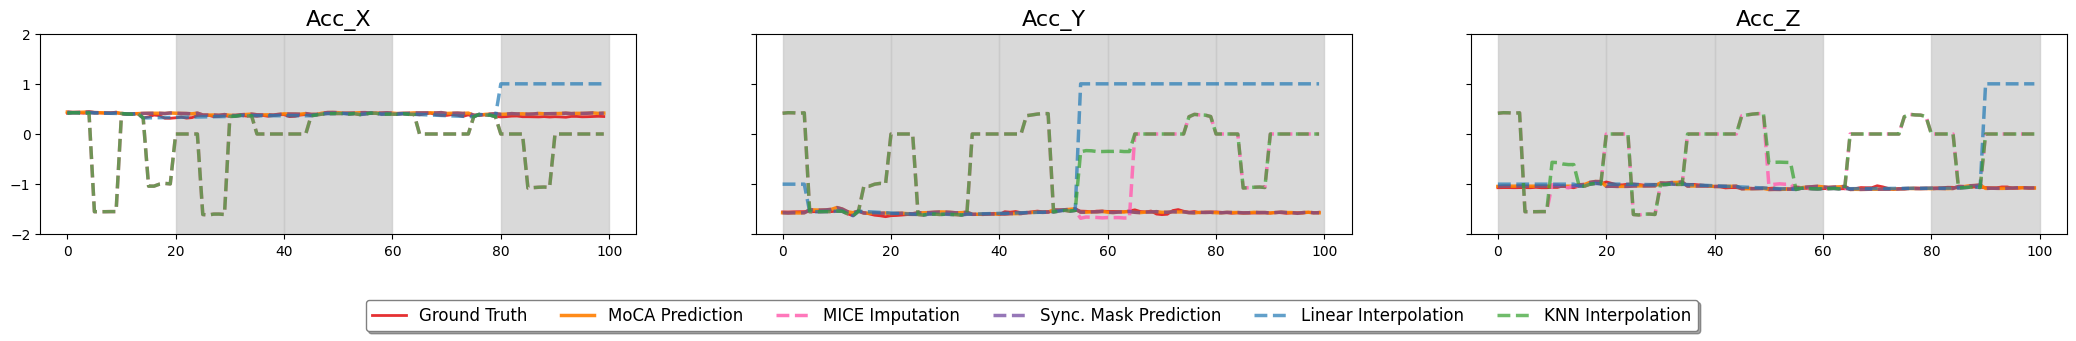

{'linear_mae': 0.3163101752397779,
 'linear_mse': 0.5732503442213783,
 'nn_mae': 0.8820082327583805,
 'nn_mse': 1.5874653057544492,
 'MAE_mae': 0.045226581394672394,
 'MAE_mse': 0.013085311278700829,
 'MICE_mae': 0.8449042774154805,
 'MICE_mse': 1.5307687992462888,
 'Sync_MAE_mae': 0.045226581394672394,
 'Sync_MAE_mse': 0.013085311278700829}

In [95]:
# test_seq
baseline(random_imput_test_set,missing_ratio=0.7,
         mask_scheme='random_imputation',model1=cross_6_200_model,model2=cross_6_200_model)

## Temporal Interpolation

Input shape: torch.Size([512, 1, 3, 100])


Imputation Progress: 100%|██████████| 512/512 [00:00<00:00, 595.79it/s]


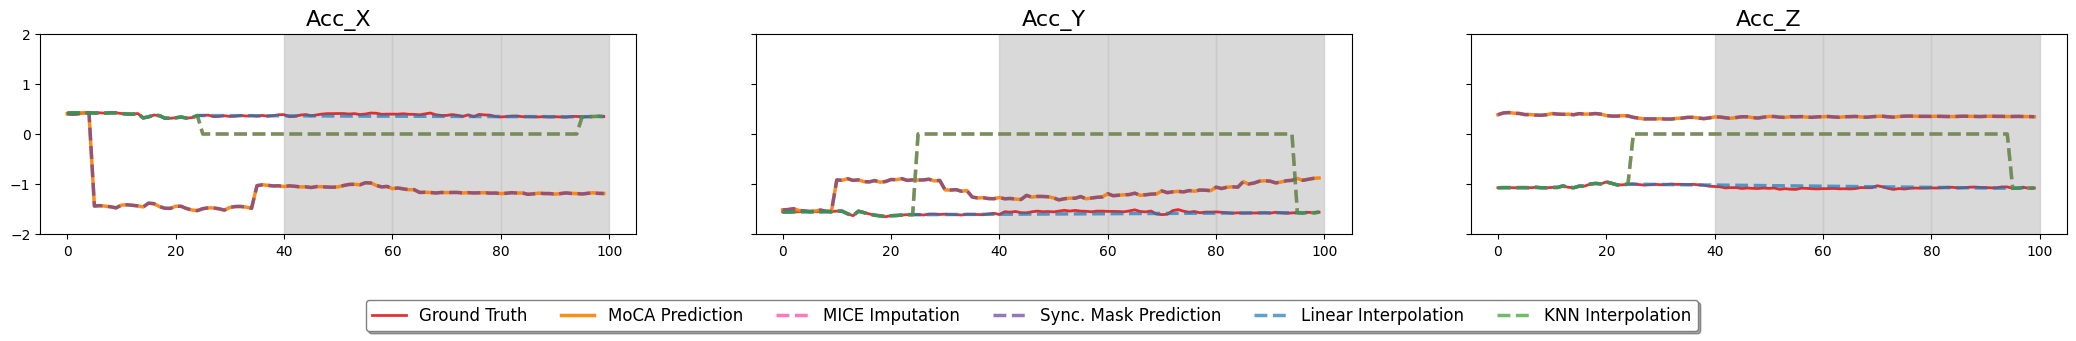

{'linear_mae': 0.29153783847448267,
 'linear_mse': 0.5114921128681075,
 'nn_mae': 0.7005206132307649,
 'nn_mse': 1.0809405129402876,
 'MAE_mae': 0.6356367468833923,
 'MAE_mse': 0.9805840849876404,
 'MICE_mae': 0.7005206132307649,
 'MICE_mse': 1.0809405129402876,
 'Sync_MAE_mae': 0.6356367468833923,
 'Sync_MAE_mse': 0.9805840849876404}

In [96]:
baseline(random_imput_test_set,missing_ratio=0.72,
         mask_scheme='temporal_imputation',model1=cross_6_200_model,model2=cross_6_200_model)

## Sensor Imputation

In [97]:
baseline(random_imput_test_set,missing_ratio=0.8,mask_scheme='sensor_imputation',
         model1=cross_6_200_model,model2=cross_6_200_model)

Input shape: torch.Size([512, 1, 3, 100])


ValueError: Found array with 0 feature(s) (shape=(3, 0)) while a minimum of 1 is required by IterativeImputer.

# Forecasting

Input shape: torch.Size([512, 1, 3, 100])














MICE Imputation: 100%|██████████| 512/512 [00:04<00:00, 122.85it/s]









Imputation Progress: 100%|██████████| 512/512 [00:00<00:00, 598.18it/s]


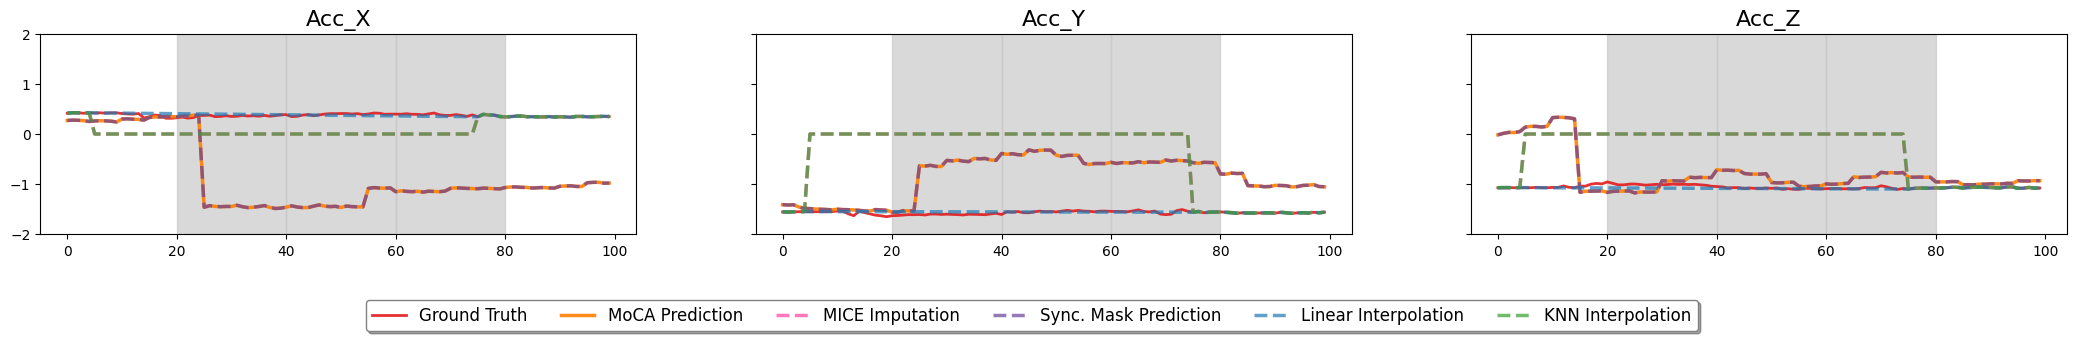

{'linear_mae': 0.2831422200590623,
 'linear_mse': 0.47286579351324765,
 'nn_mae': 0.7003098760033026,
 'nn_mse': 1.0813232333166525,
 'MAE_mae': 0.6380075216293335,
 'MAE_mse': 0.9836381077766418,
 'MICE_mae': 0.7003098760033026,
 'MICE_mse': 1.0813232333166525,
 'Sync_MAE_mae': 0.6380075216293335,
 'Sync_MAE_mse': 0.9836381077766418}

In [98]:
baseline(random_imput_test_set,missing_ratio=0.7,mask_scheme='forecasting',
         model1=cross_6_200_model,model2=cross_6_200_model)